In [2]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
import nltk
from nltk.corpus import wordnet
import time

In [8]:
DATA_PATH = "IMDB50K/IMDB Dataset.csv"
DATASET_ENCODING = "ISO-8859-1"

In [13]:
def load_data(data_path=DATA_PATH):
    return pd.read_csv(data_path, encoding=DATASET_ENCODING)

In [14]:
data = load_data()
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
data.shape

(50000, 2)

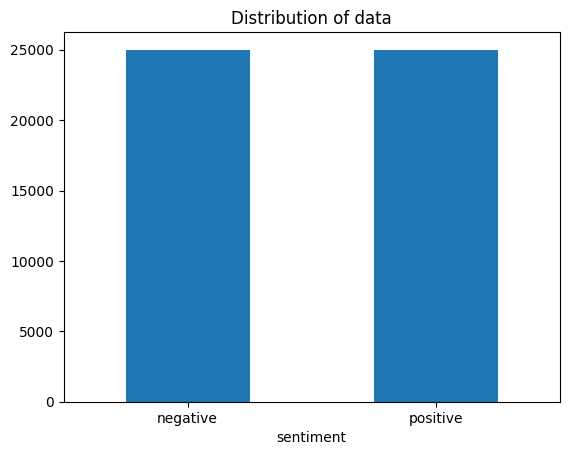

In [18]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['negative','positive'], rotation=0)

# Storing data in lists.
review, sentiment = list(data['review']), list(data['sentiment'])

The Data is balanced

In [22]:
print(f'data description: {data.describe()}')
print('-----------------------------------------')
print(f'Total null values: {data.isnull().sum()}')

data description:                                                    review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
-----------------------------------------
Total null values: review       0
sentiment    0
dtype: int64


There are some duplicates in the dataset

In [24]:
num_duplicates = data.duplicated().sum()
num_duplicates

418

There are 418 duplicates in the dataset

In [26]:
pd.set_option('display.max_rows', None)

In [ ]:
duplicate_rows = data[data.duplicated()]
duplicate_rows

Upon reviewing the 'duplicates,' I found that they are not true duplicates but rather multiple reviews of the same movies. Therefore, I will keep them in the dataset

In [28]:
emojis = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', ':-(': 'sad',
    ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked', ':@': 'shocked',
    ':-$': 'confused', ':\\': 'annoyed', ':#': 'mute', ':X': 'mute', ':^)': 'smile',
    ':-&': 'confused', '$_$': 'greedy', '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile',
    ':-0': 'yell', 'O.o': 'confused', '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile',
    ';)': 'wink', ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip',
    '=^.^=': 'cat'
}

stopwords = {
    'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an', 'and', 'any', 'are',
    'as', 'at', 'be', 'because', 'been', 'before', 'being', 'between', 'both', 'by', 'can',
    'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
    'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
    'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 
    'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'not', 'o', 'of', 'on',
    'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're', 's', 
    'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such', 't', 'than', 'that', 
    "thatll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 
    'they', 'this', 'those', 'through', 'to', 'too', 'until', 'up', 've', 'very', 'was', 
    'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 
    'with', 'won', 'y', 'you', "youd", "youll", "youre", "youve", 'your', 'yours', 'yourself', 
    'yourselves'
}

In [29]:
data= data.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
df = data.copy()

In [36]:
def preprocess(reviewdata):
    processedText = []
    
    # Creating Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for review in reviewdata:
        review = review.lower()
        # Replacing all emojis.
        for emoji in emojis.keys():
            review = review.replace(emoji, "EMOJI" + emojis[emoji])              
        # Replace all non alphabets.
        review = re.sub(alphaPattern, " ", review)
        # Replace 3 or more consecutive letters by 2 letter.
        review = re.sub(sequencePattern, seqReplacePattern, review)

        reviewswords = ''
        for word in review.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                reviewswords += (word+' ')
            
        processedText.append(reviewswords)
        
    return processedText

In [37]:
t = time.time()
processedtext = preprocess(review)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 66 seconds


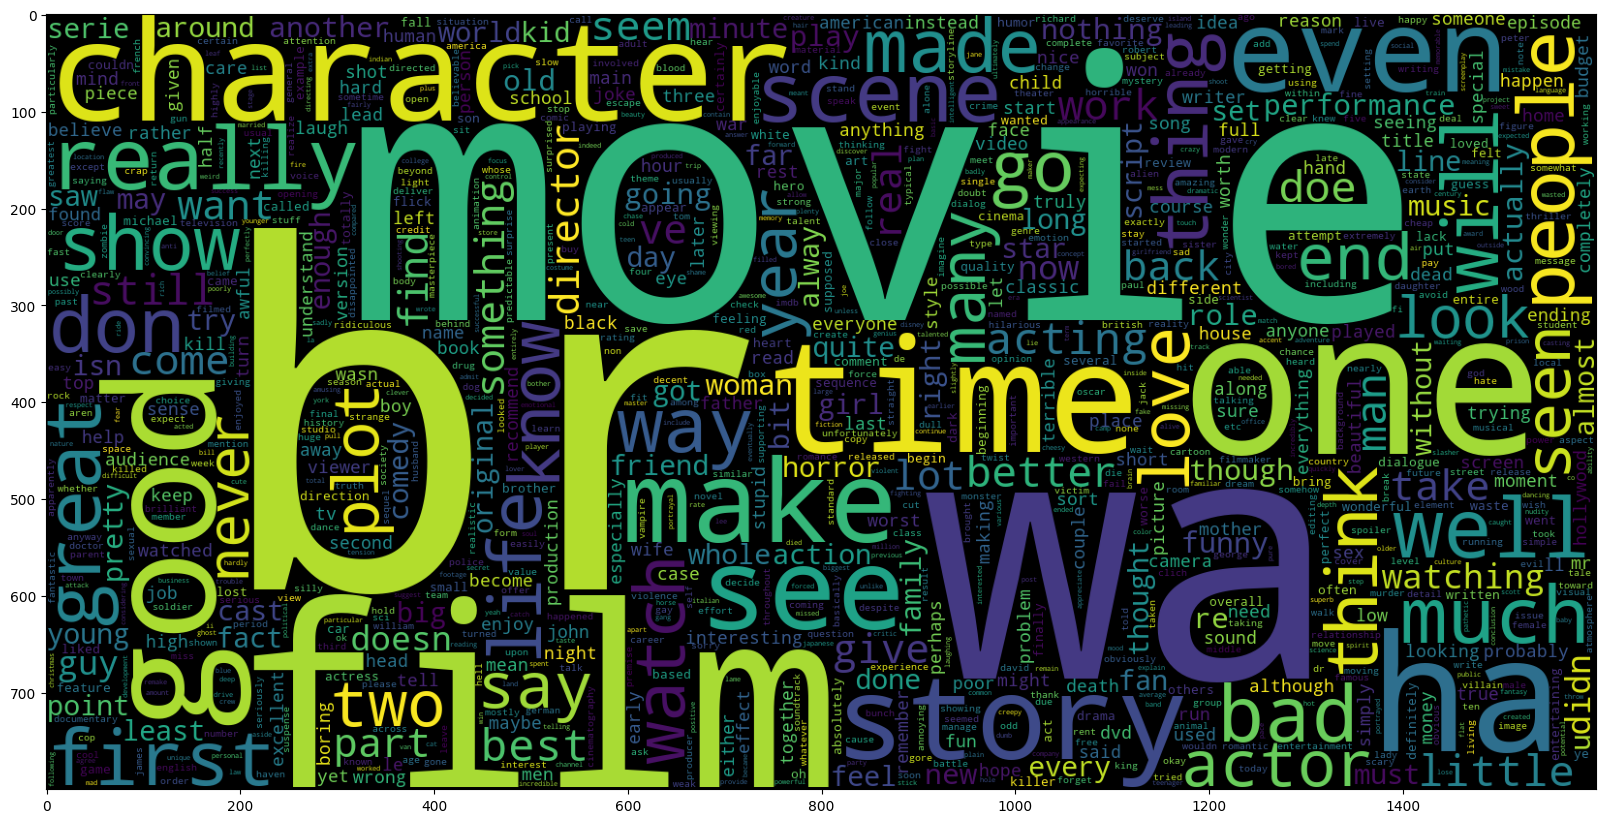

In [40]:
data_neg = processedtext[25000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

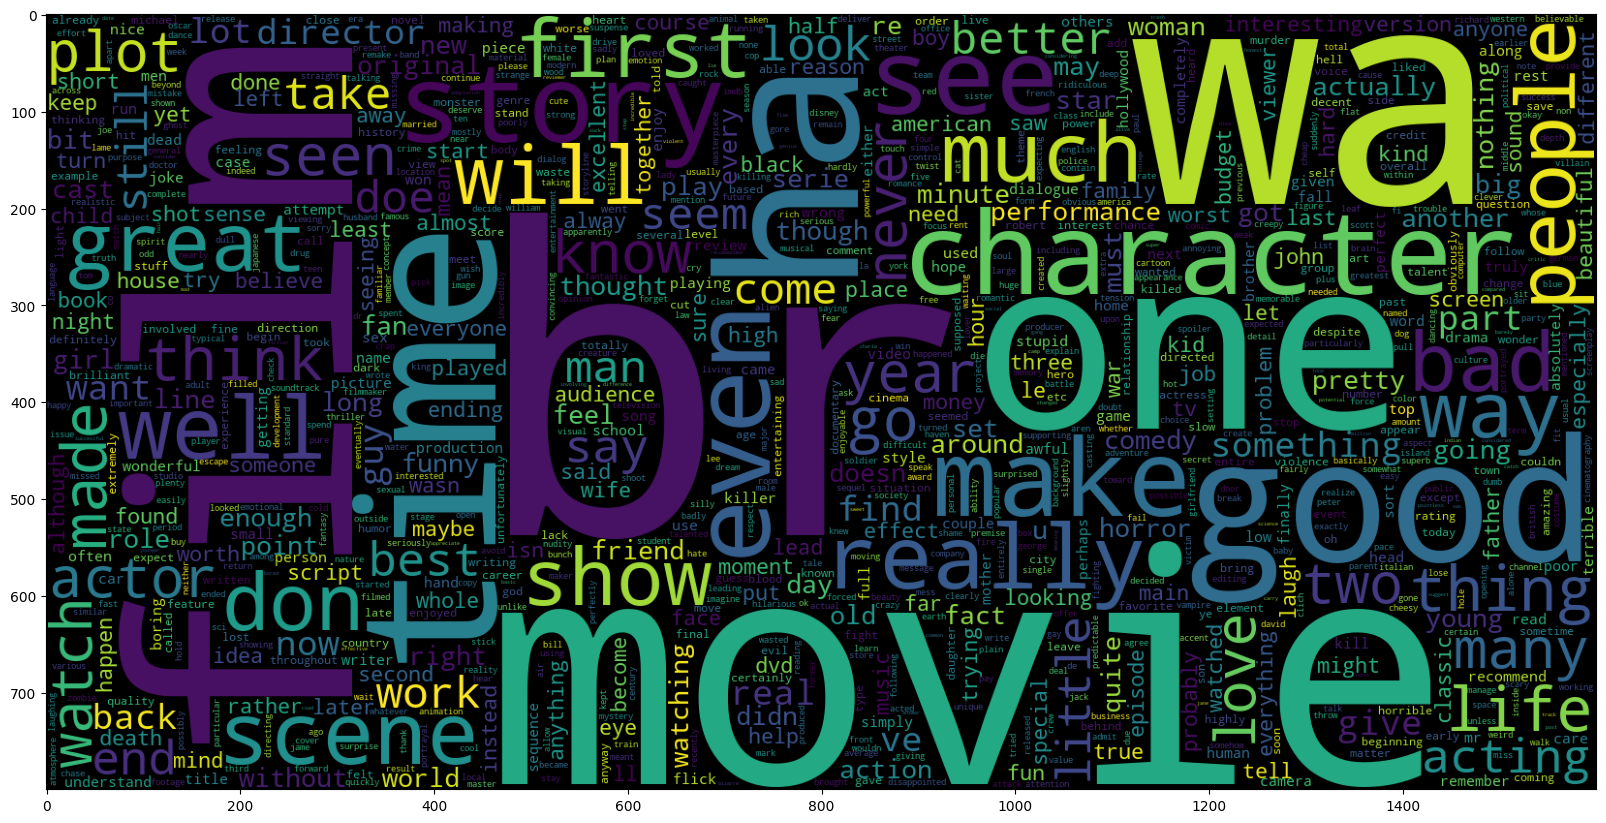

In [45]:
data_pos = processedtext[:25000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [48]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')

Vectoriser fitted.


In [49]:
feature_names = vectoriser.get_feature_names_out()
print('No. of feature_words:', len(feature_names))

No. of feature_words: 500000


In [50]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [51]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['negative','positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      1257
    positive       0.87      0.91      0.89      1243

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.89      0.89      0.89      2500



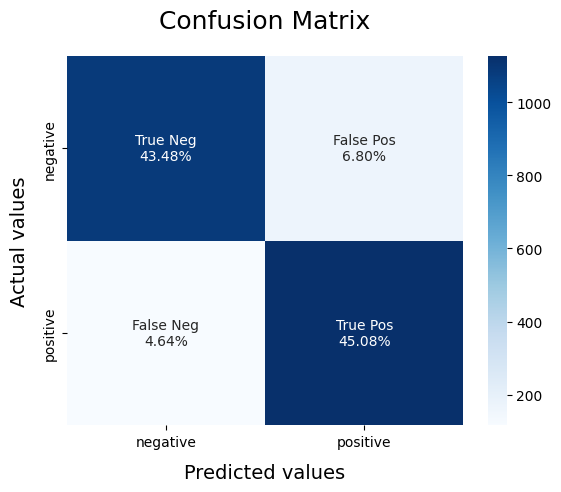

In [52]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

c:\Users\j\.vscode\llama-index-env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      1257
    positive       0.91      0.92      0.91      1243

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500



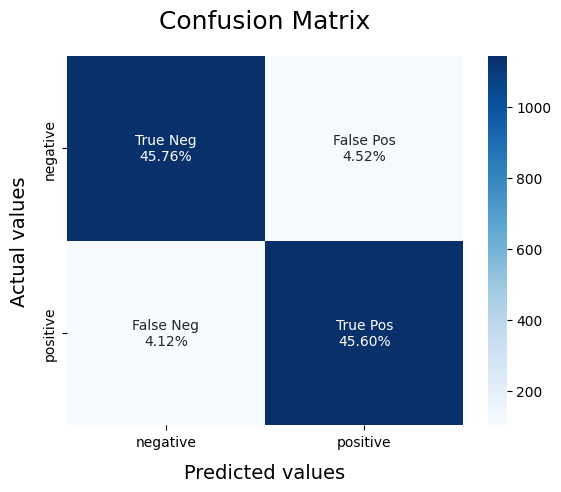

In [53]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      1257
    positive       0.90      0.92      0.91      1243

    accuracy                           0.91      2500
   macro avg       0.91      0.91      0.91      2500
weighted avg       0.91      0.91      0.91      2500



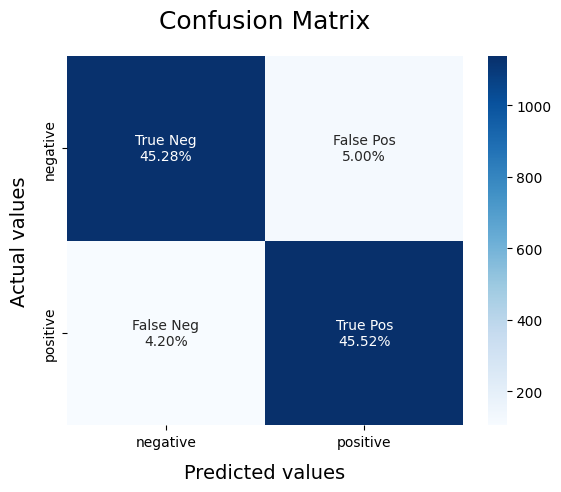

In [54]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

In [65]:
file = open('vectoriser-reviews.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

In [66]:
def load_models():
  
    
    # Load the vectoriser.
    file = open('vectoriser-reviews.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()
    
    return vectoriser, SVCmodel

In [70]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Converting the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["The acting was superb, and the plot kept me on the edge of my seat throughout the entire movie. Definitely a must-watch!",
            "I found the movie to be quite disappointing. The storyline was predictable, and the characters lacked depth. I wouldn't recommend it.",
            "This movie exceeded my expectations! The cinematography was stunning, and the performances were captivating. I was thoroughly impressed."]
    
    df = predict(vectoriser, SVCmodel, text)
    print(df)

                                                text sentiment
0  The acting was superb, and the plot kept me on...  positive
1  I found the movie to be quite disappointing. T...  negative
2  This movie exceeded my expectations! The cinem...  positive
